In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.11.7
pandas==2.1.2
numpy==1.26.1
sklearn==1.3.2
torch==2.1.1+cu121
matplotlib==3.8.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#load data
data = pd.read_csv("..\..\..\Data\Day\S&P 500 Historical Data00-20Ffill.csv")

In [5]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [6]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [7]:
data.index = data.index[::-1]

In [8]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
7255,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
7254,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
7253,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
7252,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
7251,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [9]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [10]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
7255,2010-01-02,1115.10,1126.60,1127.64,1114.81,NaN,-1.00%
7254,2010-01-03,1115.10,1126.60,1127.64,1114.81,NaN,-1.00%
7253,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
7252,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
7251,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%


In [11]:
#change indexes
special_data.set_index('Date', inplace=True)

In [12]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [13]:
special_data.head()

,Price
Date,
2010-01-02,1115.10
2010-01-03,1115.10
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14


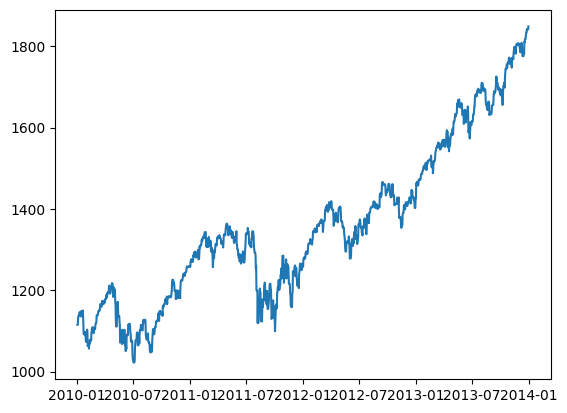

In [14]:
plt.plot(special_data)

In [30]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
val_size = int(len(training_data) * 0.1)
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [32]:
class RNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNForecast, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out

Epoch [1/300], Train Loss: 0.2800, Valid Loss: 0.6912
Epoch [11/300], Train Loss: 0.0209, Valid Loss: 0.0911
Epoch [21/300], Train Loss: 0.0181, Valid Loss: 0.1435
Epoch [31/300], Train Loss: 0.0193, Valid Loss: 0.1617
Epoch [41/300], Train Loss: 0.0158, Valid Loss: 0.1064
Epoch [51/300], Train Loss: 0.0146, Valid Loss: 0.1071
Epoch [61/300], Train Loss: 0.0134, Valid Loss: 0.1068
Epoch [71/300], Train Loss: 0.0118, Valid Loss: 0.0843
Epoch [81/300], Train Loss: 0.0096, Valid Loss: 0.0734
Epoch [91/300], Train Loss: 0.0049, Valid Loss: 0.0333
Epoch [101/300], Train Loss: 0.0008, Valid Loss: 0.0103
Epoch [111/300], Train Loss: 0.0008, Valid Loss: 0.0049
Epoch [121/300], Train Loss: 0.0006, Valid Loss: 0.0043
Epoch [131/300], Train Loss: 0.0006, Valid Loss: 0.0034
Epoch [141/300], Train Loss: 0.0006, Valid Loss: 0.0032
Epoch [151/300], Train Loss: 0.0006, Valid Loss: 0.0030
Epoch [161/300], Train Loss: 0.0006, Valid Loss: 0.0028
Epoch [171/300], Train Loss: 0.0006, Valid Loss: 0.0027
Epo

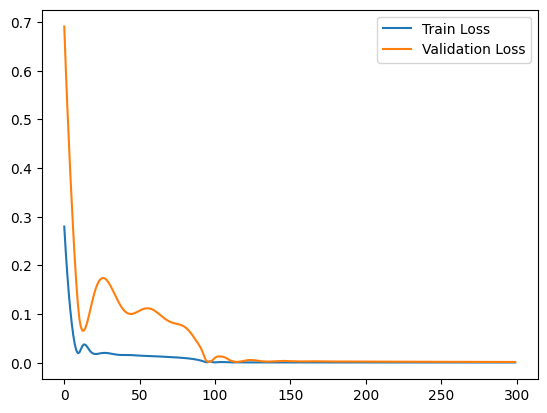

In [33]:
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

model = RNNForecast(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_loss = []
valid_loss = []
num_epochs = 300

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 32.72


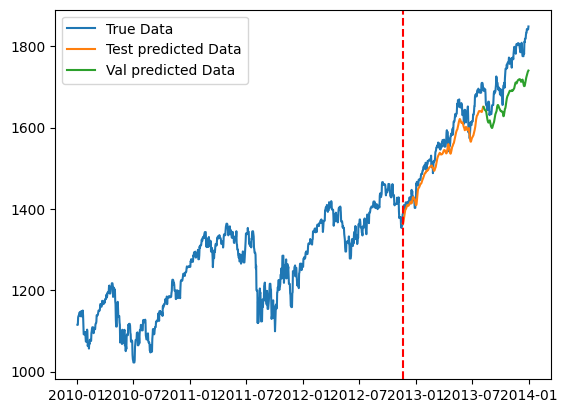

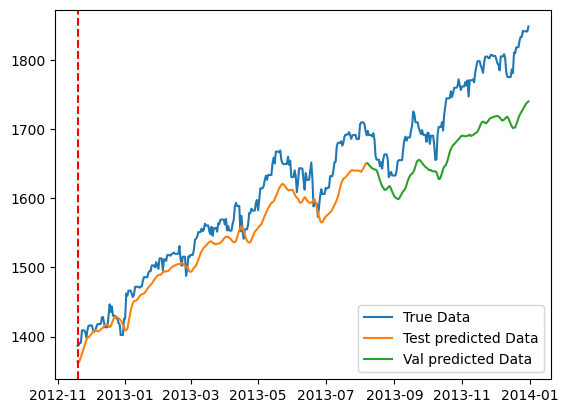

In [35]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(predY_test_inv)- val_size:], special_data.Price[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()

In [36]:
def calculate_metrics(array1, array2):
    # Проверка на совпадение длин массивов
    if len(array1) != len(array2):
        raise ValueError("Длины массивов должны совпадать")

    # Вычисление отклонений
    deviations = np.abs(np.array(array1) - np.array(array2))

    # Минимальное и максимальное отклонение
    min_deviation = np.min(deviations)
    max_deviation = np.max(deviations)

    # Процентное минимальное и максимальное отклонение
    min_deviation_percentage = min_deviation / np.max(np.abs(array1)) * 100
    max_deviation_percentage = max_deviation / np.max(np.abs(array1)) * 100
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(deviations / np.abs(array1)) * 100

    return min_deviation, max_deviation, min_deviation_percentage, max_deviation_percentage, mape


In [37]:
min_dev, max_dev, min_dev_percentage, max_dev_percentage, mape = calculate_metrics(special_data.Price[-len(predY_val_inv):].values, np.concatenate(predY_val_inv))

print(f"Минимальное отклонение: {min_dev}")
print(f"Максимальное отклонение: {max_dev}")
print(f"Процентное минимальное отклонение: {min_dev_percentage:.2f}%")
print(f"Процентное максимальное отклонение: {max_dev_percentage:.2f}%")
print(f"MAPE: {mape:.2f}%")

Минимальное отклонение: 13.399311523437518
Максимальное отклонение: 113.18467285156248
Процентное минимальное отклонение: 0.72%
Процентное максимальное отклонение: 6.12%
MAPE: 3.85%


In [38]:
len(special_data)

1460

In [39]:
len(trainX)

951

In [40]:
len(testX)

262

In [41]:
len(valX)

146

In [42]:
def save_array_to_txt(array, filename):
    # Преобразуем одномерный массив в двумерный массив с одним столбцом
    array = np.reshape(array, (len(array), 1))
    
    # Сохраняем массив в текстовый файл
    np.savetxt(filename, array, fmt='%.3f')  # fmt='%d' указывает формат данных (целые числа)

In [43]:
save_array_to_txt(np.concatenate(predY_val_inv), "rnnffill.txt")